4/4 [==============================] - 0s 0s/step
Verdaderos Positivos (TP): 4
Verdaderos Negativos (TN): 77
Falsos Positivos (FP): 27
Falsos Negativos (FN): 12
Precisión: 0.12903225806451613
Recall: 0.25
F1-Score: 0.1702127659574468
Área bajo la curva (AUC): 0.50


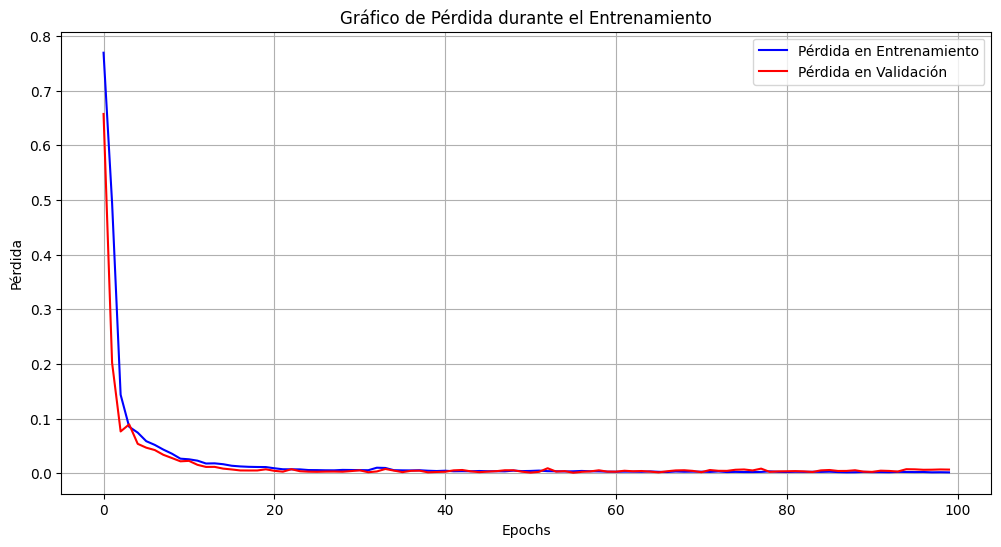

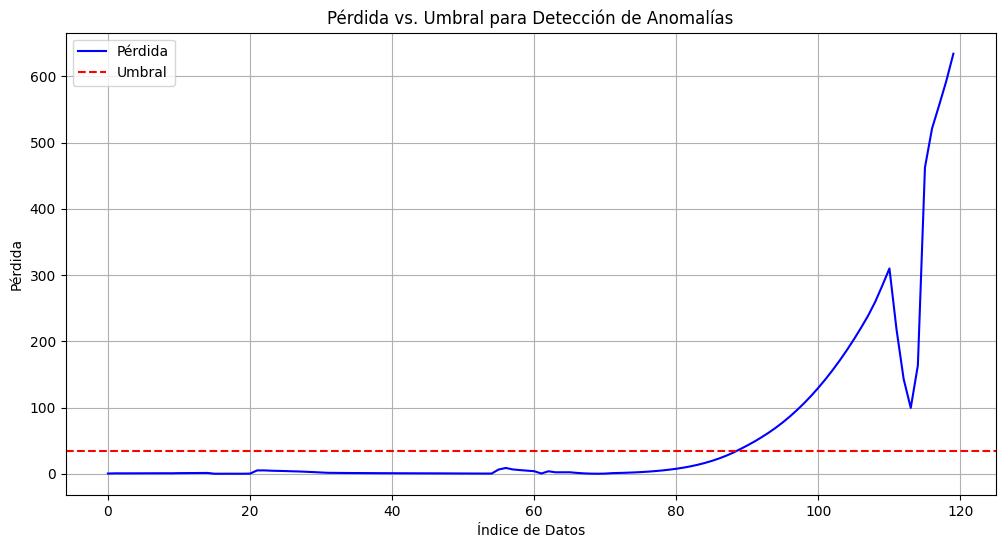

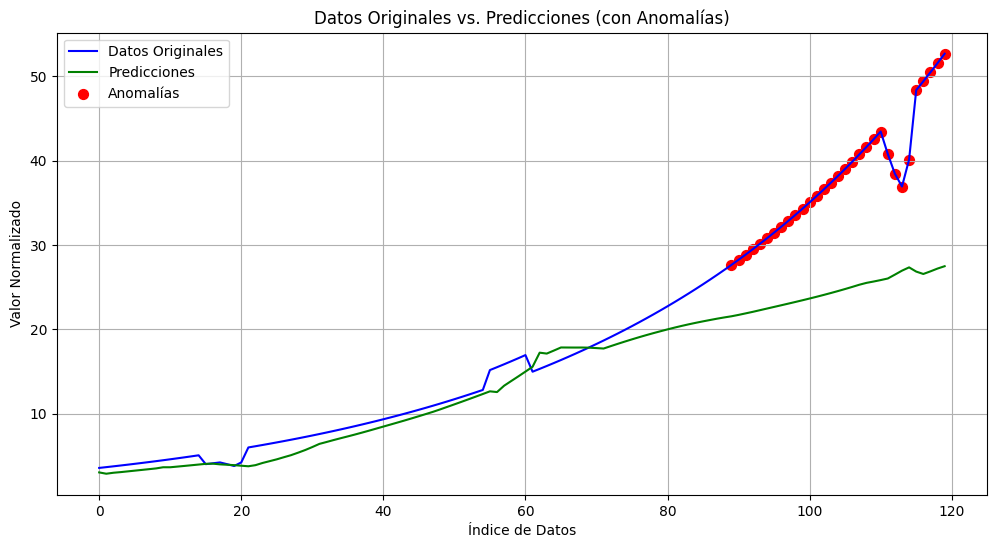

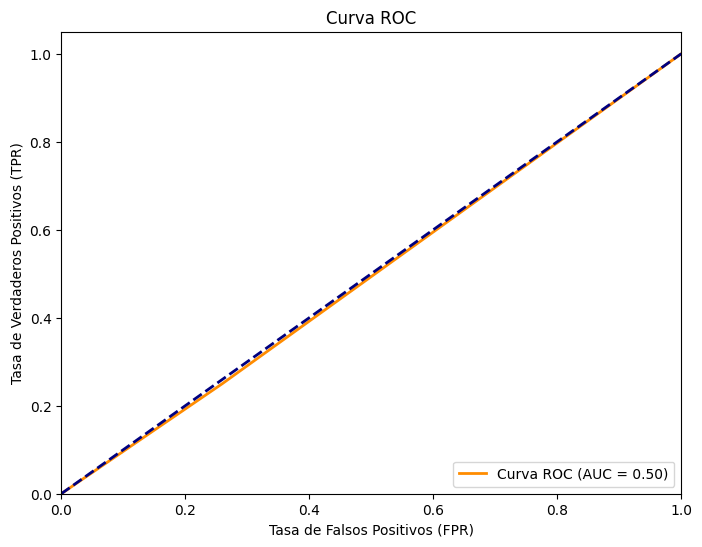

In [10]:
#IMPORTACION DE LAS LIBRERIAS A UTILIZAR

import pandas as pd #librería para analizar datos
import numpy as np #librería para algebra linear
import tensorflow as tf #librería para modelos de deep learning
import matplotlib.pyplot as plt # libreraía para realizar los graficos
import optuna # libreria para optimizar modelo
from sklearn.model_selection import train_test_split #parte de la librería que divide los datos
from sklearn.metrics import roc_curve, auc, roc_auc_score # libreria para calcular las metricas en la curva ROC
from sklearn.metrics import precision_score, recall_score, f1_score # librerias para calcular la precision, el recall y el f1 score
from sklearn.preprocessing import MinMaxScaler #libreria para estandarizacion de datos
from sklearn.preprocessing import StandardScaler #libreria para estandarizacion de datos 
from keras.models import Sequential #importar el inicio de un modelo secuencial
from keras.layers import LSTM, Dense # importa capas densas y de LSTM
from sklearn.metrics import confusion_matrix #parte de la librería para hacer la matriz de confusion
from tensorflow import keras #importa keras que se encarga de la transformacion de los datos
from spicy import stats

# cargamos datos y fijamos valores del modelo
data = pd.read_excel("anomalias2_ajustado2.xlsx")
empresa = 'claro'
empresa1 = 'claro_l'

test_size = 0.3 # longitud del testeo
valor = 1 - test_size
valor1 = valor*400
valor1 = int(valor1) #longitud del la parte de entrenamiento
TIME_STEPS = 10 #valor que se puede variar en el tiempo
epochs = 100 
batch_size = 32
etiqueta = data[empresa1][valor1:]
#PREPROCESAMIENTO DE LOS DATOS

data['valor_normalizado'] = data[empresa]
train, test = train_test_split(data['valor_normalizado'], test_size=test_size, shuffle = False)
train = pd.DataFrame(train)
test= pd.DataFrame(test)
scaler = StandardScaler()
scaler = scaler.fit(train[['valor_normalizado']])
train['valor_normalizado'] = scaler.transform(train[['valor_normalizado']])
test['valor_normalizado'] = scaler.transform(test[['valor_normalizado']])

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

X_train, y_train = create_dataset(train[['valor_normalizado']], train.valor_normalizado, TIME_STEPS)
X_test, y_test = create_dataset(test[['valor_normalizado']], test.valor_normalizado, TIME_STEPS)

#CREACION DEL MODELO AUTOENCODER CON CAPAS DENSAS
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],X_train.shape[2])),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.LSTM(32, activation='relu', return_sequences=True),  # Agregar capa LSTM
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(X_train.shape[2], activation='linear'))
])
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0) #ENTRENAMIENTO
mse = model.evaluate(X_train, X_train, verbose=0)
loss = history.history['loss']
val_loss = history.history['val_loss']

# desprocesamiento de los datos de testeo
a = pd.DataFrame(X_test[0].flat)
b = pd.DataFrame(y_test)
datos_testeo = pd.concat((a,b)).reset_index(drop=True)

#predicciones
predictions = model.predict(X_test)
predicciones1 = pd.DataFrame(predictions[0].flat)
predicciones2 = pd.DataFrame(predictions.flat)[(TIME_STEPS-1)::TIME_STEPS]
predicciones = pd.concat((predicciones1, predicciones2))
predicciones.reset_index(drop=True, inplace=True)
datos_testeo.reset_index(drop=True, inplace=True)

#calculo del error de reconstrucción
df_test = pd.DataFrame()
df_test['x_test'] = datos_testeo
df_test['predic'] = predicciones
df_test['error'] = df_test['x_test'] - df_test['predic']
df_test['error2'] = df_test['error']**2

#cálculo del threshold
mu = np.mean(df_test['error2'])  # Media
sigma = np.std(df_test['error2'])  # Desviación estándar
alpha = 0.05  # Nivel de significancia del 5%
z_score = stats.norm.ppf(1 - alpha/2)  # Utilizando la función de percentil inverso de la distribución normal
threshold = mu - (z_score * (sigma / np.sqrt(len(df_test['error2'])))) #Umbral gaussiano

anomalias = df_test[df_test['error2'] > threshold] #creación de la variable anomalias que contiene a aquellos errores mayores al umbral

#etiquetas de las anomalias
predic = pd.DataFrame()
predic = pd.DataFrame({'Valor': [0] * len(data[empresa1])})
predic.loc[anomalias.index + valor1, 'Valor'] = 1
predic = predic[valor1:]
confusion = confusion_matrix(etiqueta, predic)

TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

precision = precision_score(etiqueta, predic)
recall = recall_score(etiqueta, predic)
f1 = f1_score(etiqueta, predic)
fpr, tpr, thresholds = roc_curve(etiqueta, predic)
roc_auc = auc(fpr, tpr)
fpr, tpr, _ = roc_curve(etiqueta, predic)
roc_auc = roc_auc_score(etiqueta, predic)

print("Verdaderos Positivos (TP):", TP)
print("Verdaderos Negativos (TN):", TN)
print("Falsos Positivos (FP):", FP)
print("Falsos Negativos (FN):", FN)
print(f"Precisión: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print("Área bajo la curva (AUC): {:.2f}".format(roc_auc))

# Gráfico de Pérdida en Entrenamiento y Validación

plt.figure(figsize=(12, 6))
plt.plot(loss, label='Pérdida en Entrenamiento', color='blue')
plt.plot(val_loss, label='Pérdida en Validación', color='red')
plt.legend()
plt.title('Gráfico de Pérdida durante el Entrenamiento')
plt.xlabel('Epochs')
plt.ylabel('Pérdida')
plt.grid(True)

# Gráfico de Pérdida y Umbral para Detección de Anomalías

plt.figure(figsize=(12, 6))
plt.plot(df_test.index, df_test.error2, label='Pérdida', color='blue')
plt.axhline(y=threshold, color='red', linestyle='--', label='Umbral')
plt.title('Pérdida vs. Umbral para Detección de Anomalías')
plt.xlabel('Índice de Datos')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)

# Gráfico de Datos Originales vs. Predicciones (con Anomalías)

plt.figure(figsize=(12, 6))
plt.plot(datos_testeo, label='Datos Originales', color='blue')
plt.plot(predicciones, label='Predicciones', color='green')
plt.scatter(anomalias.index, anomalias['x_test'], color='red', label='Anomalías', marker='o', s=50)
plt.title('Datos Originales vs. Predicciones (con Anomalías)')
plt.xlabel('Índice de Datos')
plt.ylabel('Valor Normalizado')
plt.legend()
plt.grid(True)

#CURVA ROC

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

In [ ]:
y = []
for x in range(1,1000):
    y.append((x/1000))
pre = []
rec = []
f1 = []
optimos =[]
for i in y:
    threshold = i
    anomalias = df_test[df_test['error2'] > threshold]
    etiqueta = data[empresa1]
    predic = pd.DataFrame()
    predic = pd.DataFrame({'Valor': [0] * len(data[empresa1])})
    predic.loc[anomalias.index+valor1, 'Valor'] = 1
    precision = precision_score(etiqueta, predic,zero_division=0)
    recall = recall_score(etiqueta, predic,zero_division=0)
    f = f1_score(etiqueta, predic,zero_division=0)
    pre.append(precision)
    rec.append(recall)
    f1.append(f)
    
    
    if f > 0.9:
        optimos.append(threshold)

plt.figure(figsize=(10, 6))
plt.plot(pre, label='Precision', color='blue')
plt.plot(f1, label='F1 Score', color='green')
plt.plot(rec, label='Recall', color='red')
plt.legend()
plt.xlabel('Umbral')
plt.ylabel('Valor de la Métrica')
plt.title('Métricas de Clasificación en función del Umbral')
plt.grid(True) 
plt.show()

In [ ]:
# mas datos para que replique la estructura de datos de otras series de tiemp 
# cuando se hagan diferentes funciones de activacion dse ´podría adecuar a distintas series de tiempo

In [ ]:
# Convierte las listas en arrays de numpy para facilitar la manipulación
pre = np.array(pre)
rec = np.array(rec)
f1 = np.array(f1)

# Encuentra el índice del umbral que maximiza F1
indice_umbral_optimo = np.argmax(f1)

# Obtiene el umbral óptimo
umbral_optimo = y[indice_umbral_optimo]

In [ ]:
umbral_optimo

In [ ]:
#### REEMPLAZAR ###
threshold = umbral_optimo

anomalias = df_test[df_test['error2'] > threshold] #ANOMALIA DE ACUERDO A LO QUE SEA MAYOR AL THRESHOLD

# Gráfico de Pérdida en Entrenamiento y Validación

plt.figure(figsize=(12, 6))
plt.plot(loss, label='Pérdida en Entrenamiento', color='blue')
plt.plot(val_loss, label='Pérdida en Validación', color='red')
plt.legend()
plt.title('Gráfico de Pérdida durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.grid(True)

# Gráfico de Pérdida y Umbral para Detección de Anomalías

plt.figure(figsize=(12, 6))
plt.plot(df_test.index, df_test.error2, label='Pérdida', color='blue')
plt.axhline(y=threshold, color='red', linestyle='--', label='Umbral')
plt.title('Pérdida vs. Umbral para Detección de Anomalías')
plt.xlabel('Índice de Datos')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)

# Gráfico de Datos Originales vs. Predicciones (con Anomalías)

plt.figure(figsize=(12, 6))
plt.plot(datos_testeo, label='Datos Originales', color='blue')
plt.plot(predicciones, label='Predicciones', color='green')
plt.scatter(anomalias.index, anomalias['x_test'], color='red', label='Anomalías', marker='o', s=50)
plt.title('Datos Originales vs. Predicciones (con Anomalías)')
plt.xlabel('Índice de Datos')
plt.ylabel('Valor Normalizado')
plt.legend()
plt.grid(True)

#endogeneizar el umbral
#1. encontrar el umbral que maximice el recall DONE
#2. F1 score
#3. optimizar
# 
etiqueta = data[empresa1]
predic = pd.DataFrame()
predic = pd.DataFrame({'Valor': [0] * len(data[empresa1])})

predic.loc[anomalias.index + valor1, 'Valor'] = 1
confusion = confusion_matrix(etiqueta, predic)

TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

print("Verdaderos Positivos (TP):", TP)
print("Verdaderos Negativos (TN):", TN)
print("Falsos Positivos (FP):", FP)
print("Falsos Negativos (FN):", FN)
precision = precision_score(etiqueta, predic)
recall = recall_score(etiqueta, predic)
f1 = f1_score(etiqueta, predic)
print(f"Precisión: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
fpr, tpr, thresholds = roc_curve(etiqueta, predic)
roc_auc = auc(fpr, tpr)
print("Área bajo la curva (AUC): {:.2f}".format(roc_auc))


fpr, tpr, _ = roc_curve(etiqueta, predic)
roc_auc = roc_auc_score(etiqueta, predic)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

In [ ]:
#mejorar el umbral a escala log
#ajustar la data para que no sea facil los outliers, probar el cod con todas las series, 
#que el software sea el que modifique el umbral optimo
#probar LSTM y optuna last version. 

In [ ]:
# UTILIZAMOS EL MODELO CON LOS NUEVOS PARÁMETROS, Y BATCHSIZE
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2])),  # Asumiendo que X_train es un tensor 3D
    tf.keras.layers.LSTM(76, activation='relu', return_sequences=True),
    tf.keras.layers.LSTM(48, activation='relu', return_sequences=True),
    tf.keras.layers.LSTM(31, activation='relu', return_sequences=True),
    tf.keras.layers.LSTM(48, activation='relu', return_sequences=True),
    tf.keras.layers.LSTM(76, activation='relu', return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(X_train.shape[2], activation='linear'))
])
# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

In [28]:
def objective(trial):
    # Definir los espacios de búsqueda para los hiperparámetros
    num_units1 = trial.suggest_categorical('num_units1', range(64, 128))
    num_units2 = trial.suggest_categorical('num_units2', range(32, 64))
    num_units3 = trial.suggest_categorical('num_units3', range(7, 32))
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])  # Corregido
    # Crear un modelo Autoencoder
    model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],X_train.shape[2])),
    tf.keras.layers.Dense(num_units1, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_units2, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_units3, activation='relu'),
    tf.keras.layers.LSTM(num_units3, activation='relu', return_sequences=True),  # Agregar capa LSTM
    tf.keras.layers.Dense(num_units2, activation='relu'),
    tf.keras.layers.Dense(num_units1, activation='relu'),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(X_train.shape[2], activation='linear'))])

    # Compilar el modelo con los hiperparámetros seleccionados
    model.compile(optimizer='adam', loss='mean_squared_error')  # Corregido

    # Entrenar el modelo con los datos de entrenamiento y prueba
    history = model.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose = 0)

    # Calcular la métrica de interés (puede ser la precisión, el AUC, etc.)
    # En este ejemplo, usaremos la pérdida en los datos de prueba
    loss = model.evaluate(X_train, X_train)  # Corregido

    return loss

# Crear el estudio de Optuna y ejecutar la minimizacion de la pérdida
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Obtener los mejores hiperparámetros encontrados
best_params = study.best_params

# Imprimir los mejores hiperparámetros
print("Mejores hiperparámetros encontrados:", best_params)


[I 2023-10-11 14:45:05,799] A new study created in memory with name: no-name-84850fca-fd94-435d-8ddd-a3d5b1c0a74a


9/9 [==============================] - 0s 2ms/step - loss: 0.1936


[I 2023-10-11 14:45:12,486] Trial 0 finished with value: 0.19355440139770508 and parameters: {'num_units1': 66, 'num_units2': 43, 'num_units3': 30, 'batch_size': 32}. Best is trial 0 with value: 0.19355440139770508.


9/9 [==============================] - 0s 2ms/step - loss: 0.2913


[I 2023-10-11 14:45:17,956] Trial 1 finished with value: 0.29127243161201477 and parameters: {'num_units1': 102, 'num_units2': 46, 'num_units3': 10, 'batch_size': 64}. Best is trial 0 with value: 0.19355440139770508.


9/9 [==============================] - 0s 2ms/step - loss: 0.0915


[I 2023-10-11 14:45:24,112] Trial 2 finished with value: 0.09148749709129333 and parameters: {'num_units1': 94, 'num_units2': 35, 'num_units3': 29, 'batch_size': 128}. Best is trial 2 with value: 0.09148749709129333.


9/9 [==============================] - 0s 2ms/step - loss: 0.0090


[I 2023-10-11 14:45:30,058] Trial 3 finished with value: 0.008991550654172897 and parameters: {'num_units1': 121, 'num_units2': 48, 'num_units3': 25, 'batch_size': 64}. Best is trial 3 with value: 0.008991550654172897.


9/9 [==============================] - 0s 163us/step - loss: 0.0109


[I 2023-10-11 14:45:37,152] Trial 4 finished with value: 0.01087031327188015 and parameters: {'num_units1': 121, 'num_units2': 44, 'num_units3': 30, 'batch_size': 32}. Best is trial 3 with value: 0.008991550654172897.


9/9 [==============================] - 0s 2ms/step - loss: 0.0173


[I 2023-10-11 14:45:44,201] Trial 5 finished with value: 0.017329486086964607 and parameters: {'num_units1': 126, 'num_units2': 52, 'num_units3': 7, 'batch_size': 32}. Best is trial 3 with value: 0.008991550654172897.


9/9 [==============================] - 0s 3ms/step - loss: 0.1558


[I 2023-10-11 14:45:49,867] Trial 6 finished with value: 0.15582779049873352 and parameters: {'num_units1': 87, 'num_units2': 61, 'num_units3': 26, 'batch_size': 128}. Best is trial 3 with value: 0.008991550654172897.


9/9 [==============================] - 0s 2ms/step - loss: 0.1848


[I 2023-10-11 14:45:55,189] Trial 7 finished with value: 0.1847795993089676 and parameters: {'num_units1': 94, 'num_units2': 51, 'num_units3': 8, 'batch_size': 128}. Best is trial 3 with value: 0.008991550654172897.


9/9 [==============================] - 0s 2ms/step - loss: 0.1348


[I 2023-10-11 14:46:00,666] Trial 8 finished with value: 0.1347527951002121 and parameters: {'num_units1': 120, 'num_units2': 37, 'num_units3': 11, 'batch_size': 128}. Best is trial 3 with value: 0.008991550654172897.


9/9 [==============================] - 0s 2ms/step - loss: 0.0516


[I 2023-10-11 14:46:07,257] Trial 9 finished with value: 0.05156399682164192 and parameters: {'num_units1': 124, 'num_units2': 57, 'num_units3': 30, 'batch_size': 64}. Best is trial 3 with value: 0.008991550654172897.


9/9 [==============================] - 0s 2ms/step - loss: 0.0328


[I 2023-10-11 14:46:16,196] Trial 10 finished with value: 0.03283488750457764 and parameters: {'num_units1': 106, 'num_units2': 48, 'num_units3': 13, 'batch_size': 16}. Best is trial 3 with value: 0.008991550654172897.


9/9 [==============================] - 0s 2ms/step - loss: 0.4037


[I 2023-10-11 14:46:23,212] Trial 11 finished with value: 0.4036616086959839 and parameters: {'num_units1': 121, 'num_units2': 44, 'num_units3': 25, 'batch_size': 32}. Best is trial 3 with value: 0.008991550654172897.


9/9 [==============================] - 0s 2ms/step - loss: 0.1167


[I 2023-10-11 14:46:29,320] Trial 12 finished with value: 0.1167386919260025 and parameters: {'num_units1': 121, 'num_units2': 62, 'num_units3': 22, 'batch_size': 64}. Best is trial 3 with value: 0.008991550654172897.


9/9 [==============================] - 0s 1ms/step - loss: 0.0370


[I 2023-10-11 14:46:37,939] Trial 13 finished with value: 0.0369999073445797 and parameters: {'num_units1': 83, 'num_units2': 48, 'num_units3': 21, 'batch_size': 16}. Best is trial 3 with value: 0.008991550654172897.


9/9 [==============================] - 0s 1ms/step - loss: 0.0485


[I 2023-10-11 14:46:45,144] Trial 14 finished with value: 0.04846172407269478 and parameters: {'num_units1': 109, 'num_units2': 44, 'num_units3': 24, 'batch_size': 32}. Best is trial 3 with value: 0.008991550654172897.


9/9 [==============================] - 0s 5ms/step - loss: 0.0343


[I 2023-10-11 14:46:51,084] Trial 15 finished with value: 0.034348923712968826 and parameters: {'num_units1': 121, 'num_units2': 47, 'num_units3': 23, 'batch_size': 64}. Best is trial 3 with value: 0.008991550654172897.


9/9 [==============================] - 0s 2ms/step - loss: 0.0156


[I 2023-10-11 14:46:56,985] Trial 16 finished with value: 0.015559581108391285 and parameters: {'num_units1': 86, 'num_units2': 42, 'num_units3': 19, 'batch_size': 64}. Best is trial 3 with value: 0.008991550654172897.


9/9 [==============================] - 0s 2ms/step - loss: 0.0955


[I 2023-10-11 14:47:03,770] Trial 17 finished with value: 0.09551863372325897 and parameters: {'num_units1': 119, 'num_units2': 63, 'num_units3': 25, 'batch_size': 32}. Best is trial 3 with value: 0.008991550654172897.


9/9 [==============================] - 0s 2ms/step - loss: 0.0613


[I 2023-10-11 14:47:12,124] Trial 18 finished with value: 0.06128564104437828 and parameters: {'num_units1': 70, 'num_units2': 55, 'num_units3': 15, 'batch_size': 16}. Best is trial 3 with value: 0.008991550654172897.


9/9 [==============================] - 0s 0s/step - loss: 0.0718 


[I 2023-10-11 14:47:18,573] Trial 19 finished with value: 0.07182948291301727 and parameters: {'num_units1': 88, 'num_units2': 60, 'num_units3': 20, 'batch_size': 32}. Best is trial 3 with value: 0.008991550654172897.


9/9 [==============================] - 0s 2ms/step - loss: 0.0155


[I 2023-10-11 14:47:24,527] Trial 20 finished with value: 0.01554683968424797 and parameters: {'num_units1': 82, 'num_units2': 41, 'num_units3': 18, 'batch_size': 64}. Best is trial 3 with value: 0.008991550654172897.


9/9 [==============================] - 0s 2ms/step - loss: 0.1700


[I 2023-10-11 14:47:30,033] Trial 21 finished with value: 0.17001913487911224 and parameters: {'num_units1': 103, 'num_units2': 39, 'num_units3': 18, 'batch_size': 64}. Best is trial 3 with value: 0.008991550654172897.


9/9 [==============================] - 0s 2ms/step - loss: 0.5544


[I 2023-10-11 14:47:35,611] Trial 22 finished with value: 0.5543966889381409 and parameters: {'num_units1': 117, 'num_units2': 41, 'num_units3': 18, 'batch_size': 64}. Best is trial 3 with value: 0.008991550654172897.


9/9 [==============================] - 0s 1ms/step - loss: 0.0754


[I 2023-10-11 14:47:40,810] Trial 23 finished with value: 0.07543045282363892 and parameters: {'num_units1': 82, 'num_units2': 34, 'num_units3': 16, 'batch_size': 64}. Best is trial 3 with value: 0.008991550654172897.


9/9 [==============================] - 0s 2ms/step - loss: 0.0358


[I 2023-10-11 14:47:46,179] Trial 24 finished with value: 0.03580338507890701 and parameters: {'num_units1': 115, 'num_units2': 41, 'num_units3': 12, 'batch_size': 64}. Best is trial 3 with value: 0.008991550654172897.


9/9 [==============================] - 0s 2ms/step - loss: 0.0391


[I 2023-10-11 14:47:51,484] Trial 25 finished with value: 0.03912471607327461 and parameters: {'num_units1': 82, 'num_units2': 50, 'num_units3': 31, 'batch_size': 64}. Best is trial 3 with value: 0.008991550654172897.


9/9 [==============================] - 0s 1ms/step - loss: 0.0989


[I 2023-10-11 14:47:57,616] Trial 26 finished with value: 0.09887375682592392 and parameters: {'num_units1': 78, 'num_units2': 36, 'num_units3': 9, 'batch_size': 32}. Best is trial 3 with value: 0.008991550654172897.


9/9 [==============================] - 0s 30us/step - loss: 0.0605


[I 2023-10-11 14:48:05,520] Trial 27 finished with value: 0.0605466291308403 and parameters: {'num_units1': 92, 'num_units2': 32, 'num_units3': 27, 'batch_size': 16}. Best is trial 3 with value: 0.008991550654172897.


9/9 [==============================] - 0s 2ms/step - loss: 0.0298


[I 2023-10-11 14:48:10,811] Trial 28 finished with value: 0.029804646968841553 and parameters: {'num_units1': 100, 'num_units2': 45, 'num_units3': 17, 'batch_size': 64}. Best is trial 3 with value: 0.008991550654172897.


9/9 [==============================] - 0s 0s/step - loss: 0.0128


[I 2023-10-11 14:48:16,953] Trial 29 finished with value: 0.012770669534802437 and parameters: {'num_units1': 99, 'num_units2': 40, 'num_units3': 28, 'batch_size': 32}. Best is trial 3 with value: 0.008991550654172897.


9/9 [==============================] - 0s 1ms/step - loss: 0.0472


[I 2023-10-11 14:48:22,977] Trial 30 finished with value: 0.047217462211847305 and parameters: {'num_units1': 74, 'num_units2': 40, 'num_units3': 28, 'batch_size': 32}. Best is trial 3 with value: 0.008991550654172897.


9/9 [==============================] - 0s 0s/step - loss: 0.0246


[I 2023-10-11 14:48:29,859] Trial 31 finished with value: 0.024600517004728317 and parameters: {'num_units1': 99, 'num_units2': 58, 'num_units3': 30, 'batch_size': 32}. Best is trial 3 with value: 0.008991550654172897.


9/9 [==============================] - 0s 0s/step - loss: 0.1202 


[I 2023-10-11 14:48:36,103] Trial 32 finished with value: 0.12015126645565033 and parameters: {'num_units1': 65, 'num_units2': 49, 'num_units3': 14, 'batch_size': 32}. Best is trial 3 with value: 0.008991550654172897.


9/9 [==============================] - 0s 2ms/step - loss: 0.0454


[I 2023-10-11 14:48:42,425] Trial 33 finished with value: 0.04536713659763336 and parameters: {'num_units1': 81, 'num_units2': 54, 'num_units3': 28, 'batch_size': 32}. Best is trial 3 with value: 0.008991550654172897.


9/9 [==============================] - 0s 2ms/step - loss: 0.0736


[I 2023-10-11 14:48:48,514] Trial 34 finished with value: 0.07356298714876175 and parameters: {'num_units1': 77, 'num_units2': 59, 'num_units3': 10, 'batch_size': 32}. Best is trial 3 with value: 0.008991550654172897.


9/9 [==============================] - 0s 2ms/step - loss: 0.1140


[I 2023-10-11 14:48:53,794] Trial 35 finished with value: 0.11403705179691315 and parameters: {'num_units1': 91, 'num_units2': 33, 'num_units3': 29, 'batch_size': 64}. Best is trial 3 with value: 0.008991550654172897.


9/9 [==============================] - 0s 2ms/step - loss: 0.0656


[I 2023-10-11 14:48:58,232] Trial 36 finished with value: 0.06560324132442474 and parameters: {'num_units1': 95, 'num_units2': 38, 'num_units3': 7, 'batch_size': 128}. Best is trial 3 with value: 0.008991550654172897.


9/9 [==============================] - 0s 2ms/step - loss: 0.1088


[I 2023-10-11 14:49:04,592] Trial 37 finished with value: 0.10878763347864151 and parameters: {'num_units1': 107, 'num_units2': 56, 'num_units3': 28, 'batch_size': 32}. Best is trial 3 with value: 0.008991550654172897.


9/9 [==============================] - 0s 2ms/step - loss: 0.0147


[I 2023-10-11 14:49:09,839] Trial 38 finished with value: 0.014711183495819569 and parameters: {'num_units1': 72, 'num_units2': 53, 'num_units3': 26, 'batch_size': 128}. Best is trial 3 with value: 0.008991550654172897.


9/9 [==============================] - 0s 0s/step - loss: 0.0564


[I 2023-10-11 14:49:14,672] Trial 39 finished with value: 0.05640127509832382 and parameters: {'num_units1': 72, 'num_units2': 43, 'num_units3': 30, 'batch_size': 128}. Best is trial 3 with value: 0.008991550654172897.


9/9 [==============================] - 0s 0s/step - loss: 0.1423


[I 2023-10-11 14:49:19,838] Trial 40 finished with value: 0.1423027664422989 and parameters: {'num_units1': 114, 'num_units2': 53, 'num_units3': 26, 'batch_size': 128}. Best is trial 3 with value: 0.008991550654172897.


9/9 [==============================] - 0s 1ms/step - loss: 0.0408


[I 2023-10-11 14:49:24,700] Trial 41 finished with value: 0.0407852903008461 and parameters: {'num_units1': 80, 'num_units2': 40, 'num_units3': 25, 'batch_size': 128}. Best is trial 3 with value: 0.008991550654172897.


9/9 [==============================] - 0s 2ms/step - loss: 0.2089


[I 2023-10-11 14:49:29,674] Trial 42 finished with value: 0.2088899165391922 and parameters: {'num_units1': 113, 'num_units2': 46, 'num_units3': 26, 'batch_size': 128}. Best is trial 3 with value: 0.008991550654172897.


9/9 [==============================] - 0s 2ms/step - loss: 0.1175


[I 2023-10-11 14:49:34,574] Trial 43 finished with value: 0.1174980029463768 and parameters: {'num_units1': 108, 'num_units2': 53, 'num_units3': 8, 'batch_size': 128}. Best is trial 3 with value: 0.008991550654172897.


9/9 [==============================] - 0s 0s/step - loss: 0.0231 


[I 2023-10-11 14:49:40,620] Trial 44 finished with value: 0.023143453523516655 and parameters: {'num_units1': 110, 'num_units2': 52, 'num_units3': 11, 'batch_size': 64}. Best is trial 3 with value: 0.008991550654172897.


9/9 [==============================] - 0s 0s/step - loss: 0.0356 


[I 2023-10-11 14:49:48,489] Trial 45 finished with value: 0.035632360726594925 and parameters: {'num_units1': 105, 'num_units2': 35, 'num_units3': 18, 'batch_size': 16}. Best is trial 3 with value: 0.008991550654172897.


9/9 [==============================] - 0s 2ms/step - loss: 0.0980


[I 2023-10-11 14:49:55,239] Trial 46 finished with value: 0.098049096763134 and parameters: {'num_units1': 118, 'num_units2': 48, 'num_units3': 22, 'batch_size': 32}. Best is trial 3 with value: 0.008991550654172897.


9/9 [==============================] - 0s 2ms/step - loss: 0.0156


[I 2023-10-11 14:50:00,164] Trial 47 finished with value: 0.01562425121665001 and parameters: {'num_units1': 84, 'num_units2': 44, 'num_units3': 21, 'batch_size': 128}. Best is trial 3 with value: 0.008991550654172897.


9/9 [==============================] - 0s 2ms/step - loss: 0.2710


[I 2023-10-11 14:50:05,648] Trial 48 finished with value: 0.27101609110832214 and parameters: {'num_units1': 89, 'num_units2': 62, 'num_units3': 13, 'batch_size': 64}. Best is trial 3 with value: 0.008991550654172897.


9/9 [==============================] - 0s 2ms/step - loss: 0.5363


[I 2023-10-11 14:50:12,342] Trial 49 finished with value: 0.536288321018219 and parameters: {'num_units1': 76, 'num_units2': 57, 'num_units3': 23, 'batch_size': 32}. Best is trial 3 with value: 0.008991550654172897.


9/9 [==============================] - 0s 2ms/step - loss: 0.0614


[I 2023-10-11 14:50:18,751] Trial 50 finished with value: 0.061362139880657196 and parameters: {'num_units1': 127, 'num_units2': 61, 'num_units3': 26, 'batch_size': 64}. Best is trial 3 with value: 0.008991550654172897.


9/9 [==============================] - 0s 2ms/step - loss: 1.9879


[I 2023-10-11 14:50:23,997] Trial 51 finished with value: 1.9878714084625244 and parameters: {'num_units1': 85, 'num_units2': 37, 'num_units3': 19, 'batch_size': 64}. Best is trial 3 with value: 0.008991550654172897.


9/9 [==============================] - 0s 3ms/step - loss: 0.0959


[I 2023-10-11 14:50:29,245] Trial 52 finished with value: 0.09585577249526978 and parameters: {'num_units1': 97, 'num_units2': 42, 'num_units3': 19, 'batch_size': 64}. Best is trial 3 with value: 0.008991550654172897.


9/9 [==============================] - 0s 2ms/step - loss: 0.0969


[I 2023-10-11 14:50:34,838] Trial 53 finished with value: 0.09692083299160004 and parameters: {'num_units1': 121, 'num_units2': 51, 'num_units3': 24, 'batch_size': 64}. Best is trial 3 with value: 0.008991550654172897.


9/9 [==============================] - 0s 813us/step - loss: 0.0675


[I 2023-10-11 14:50:40,105] Trial 54 finished with value: 0.06750448793172836 and parameters: {'num_units1': 86, 'num_units2': 42, 'num_units3': 19, 'batch_size': 64}. Best is trial 3 with value: 0.008991550654172897.


9/9 [==============================] - 0s 2ms/step - loss: 0.0062


[I 2023-10-11 14:50:48,173] Trial 55 finished with value: 0.006159050855785608 and parameters: {'num_units1': 101, 'num_units2': 48, 'num_units3': 25, 'batch_size': 16}. Best is trial 55 with value: 0.006159050855785608.


9/9 [==============================] - 0s 0s/step - loss: 0.0161 


[I 2023-10-11 14:50:56,892] Trial 56 finished with value: 0.016063015908002853 and parameters: {'num_units1': 125, 'num_units2': 48, 'num_units3': 25, 'batch_size': 16}. Best is trial 55 with value: 0.006159050855785608.


9/9 [==============================] - 0s 2ms/step - loss: 0.0163


[I 2023-10-11 14:51:05,096] Trial 57 finished with value: 0.0163311455398798 and parameters: {'num_units1': 101, 'num_units2': 48, 'num_units3': 25, 'batch_size': 16}. Best is trial 55 with value: 0.006159050855785608.


9/9 [==============================] - 0s 0s/step - loss: 0.2562


[I 2023-10-11 14:51:12,723] Trial 58 finished with value: 0.2562122642993927 and parameters: {'num_units1': 67, 'num_units2': 41, 'num_units3': 20, 'batch_size': 16}. Best is trial 55 with value: 0.006159050855785608.


9/9 [==============================] - 0s 2ms/step - loss: 0.0503


[I 2023-10-11 14:51:21,077] Trial 59 finished with value: 0.050267621874809265 and parameters: {'num_units1': 123, 'num_units2': 47, 'num_units3': 16, 'batch_size': 16}. Best is trial 55 with value: 0.006159050855785608.


9/9 [==============================] - 0s 3ms/step - loss: 0.1483


[I 2023-10-11 14:51:28,817] Trial 60 finished with value: 0.14827850461006165 and parameters: {'num_units1': 79, 'num_units2': 55, 'num_units3': 15, 'batch_size': 16}. Best is trial 55 with value: 0.006159050855785608.


9/9 [==============================] - 0s 2ms/step - loss: 0.0310


[I 2023-10-11 14:51:33,812] Trial 61 finished with value: 0.03099638596177101 and parameters: {'num_units1': 64, 'num_units2': 44, 'num_units3': 30, 'batch_size': 64}. Best is trial 55 with value: 0.006159050855785608.


9/9 [==============================] - 0s 2ms/step - loss: 0.0049


[I 2023-10-11 14:51:40,481] Trial 62 finished with value: 0.004922423046082258 and parameters: {'num_units1': 98, 'num_units2': 63, 'num_units3': 12, 'batch_size': 32}. Best is trial 62 with value: 0.004922423046082258.


9/9 [==============================] - 0s 2ms/step - loss: 0.0451


[I 2023-10-11 14:51:46,664] Trial 63 finished with value: 0.04506831243634224 and parameters: {'num_units1': 98, 'num_units2': 63, 'num_units3': 12, 'batch_size': 32}. Best is trial 62 with value: 0.004922423046082258.


9/9 [==============================] - 0s 4ms/step - loss: 0.0310


[I 2023-10-11 14:51:53,338] Trial 64 finished with value: 0.03097037971019745 and parameters: {'num_units1': 116, 'num_units2': 63, 'num_units3': 31, 'batch_size': 32}. Best is trial 62 with value: 0.004922423046082258.


9/9 [==============================] - 0s 2ms/step - loss: 0.0040


[I 2023-10-11 14:51:59,081] Trial 65 finished with value: 0.004019358195364475 and parameters: {'num_units1': 71, 'num_units2': 39, 'num_units3': 9, 'batch_size': 32}. Best is trial 65 with value: 0.004019358195364475.


9/9 [==============================] - 0s 2ms/step - loss: 0.0340


[I 2023-10-11 14:52:04,641] Trial 66 finished with value: 0.03396879881620407 and parameters: {'num_units1': 71, 'num_units2': 39, 'num_units3': 9, 'batch_size': 32}. Best is trial 65 with value: 0.004019358195364475.


9/9 [==============================] - 0s 1ms/step - loss: 0.0513


[I 2023-10-11 14:52:10,905] Trial 67 finished with value: 0.05128863826394081 and parameters: {'num_units1': 111, 'num_units2': 39, 'num_units3': 12, 'batch_size': 32}. Best is trial 65 with value: 0.004019358195364475.


9/9 [==============================] - 0s 0s/step - loss: 0.5688 


[I 2023-10-11 14:52:17,906] Trial 68 finished with value: 0.5688459873199463 and parameters: {'num_units1': 102, 'num_units2': 60, 'num_units3': 9, 'batch_size': 32}. Best is trial 65 with value: 0.004019358195364475.


9/9 [==============================] - 0s 2ms/step - loss: 0.0265


[I 2023-10-11 14:52:24,110] Trial 69 finished with value: 0.026514068245887756 and parameters: {'num_units1': 73, 'num_units2': 34, 'num_units3': 14, 'batch_size': 32}. Best is trial 65 with value: 0.004019358195364475.


9/9 [==============================] - 0s 2ms/step - loss: 0.1098


[I 2023-10-11 14:52:30,680] Trial 70 finished with value: 0.10980196297168732 and parameters: {'num_units1': 104, 'num_units2': 40, 'num_units3': 27, 'batch_size': 32}. Best is trial 65 with value: 0.004019358195364475.


9/9 [==============================] - 0s 3ms/step - loss: 0.3476


[I 2023-10-11 14:52:37,330] Trial 71 finished with value: 0.3475895822048187 and parameters: {'num_units1': 122, 'num_units2': 50, 'num_units3': 17, 'batch_size': 32}. Best is trial 65 with value: 0.004019358195364475.


9/9 [==============================] - 0s 2ms/step - loss: 0.0343


[I 2023-10-11 14:52:43,529] Trial 72 finished with value: 0.03430165722966194 and parameters: {'num_units1': 126, 'num_units2': 36, 'num_units3': 18, 'batch_size': 32}. Best is trial 65 with value: 0.004019358195364475.


9/9 [==============================] - 0s 2ms/step - loss: 0.0291


[I 2023-10-11 14:52:48,932] Trial 73 finished with value: 0.029097648337483406 and parameters: {'num_units1': 99, 'num_units2': 53, 'num_units3': 25, 'batch_size': 128}. Best is trial 65 with value: 0.004019358195364475.


9/9 [==============================] - 0s 2ms/step - loss: 0.0188


[I 2023-10-11 14:52:55,347] Trial 74 finished with value: 0.01875750534236431 and parameters: {'num_units1': 112, 'num_units2': 32, 'num_units3': 28, 'batch_size': 32}. Best is trial 65 with value: 0.004019358195364475.


9/9 [==============================] - 0s 2ms/step - loss: 0.0289


[I 2023-10-11 14:53:02,016] Trial 75 finished with value: 0.028944630175828934 and parameters: {'num_units1': 90, 'num_units2': 45, 'num_units3': 7, 'batch_size': 32}. Best is trial 65 with value: 0.004019358195364475.


9/9 [==============================] - 0s 2ms/step - loss: 0.2868


[I 2023-10-11 14:53:09,583] Trial 76 finished with value: 0.286776602268219 and parameters: {'num_units1': 69, 'num_units2': 41, 'num_units3': 10, 'batch_size': 16}. Best is trial 65 with value: 0.004019358195364475.


9/9 [==============================] - 0s 2ms/step - loss: 0.0140


[I 2023-10-11 14:53:14,318] Trial 77 finished with value: 0.014043622650206089 and parameters: {'num_units1': 72, 'num_units2': 49, 'num_units3': 29, 'batch_size': 128}. Best is trial 65 with value: 0.004019358195364475.


9/9 [==============================] - 0s 2ms/step - loss: 0.0543


[I 2023-10-11 14:53:19,010] Trial 78 finished with value: 0.05432882159948349 and parameters: {'num_units1': 72, 'num_units2': 48, 'num_units3': 29, 'batch_size': 128}. Best is trial 65 with value: 0.004019358195364475.


9/9 [==============================] - 0s 0s/step - loss: 0.1766 


[I 2023-10-11 14:53:23,891] Trial 79 finished with value: 0.17655687034130096 and parameters: {'num_units1': 93, 'num_units2': 49, 'num_units3': 9, 'batch_size': 128}. Best is trial 65 with value: 0.004019358195364475.


9/9 [==============================] - 0s 2ms/step - loss: 0.0445


[I 2023-10-11 14:53:28,930] Trial 80 finished with value: 0.044502779841423035 and parameters: {'num_units1': 96, 'num_units2': 49, 'num_units3': 30, 'batch_size': 128}. Best is trial 65 with value: 0.004019358195364475.


9/9 [==============================] - 0s 2ms/step - loss: 0.0193


[I 2023-10-11 14:53:33,902] Trial 81 finished with value: 0.019303742796182632 and parameters: {'num_units1': 66, 'num_units2': 58, 'num_units3': 29, 'batch_size': 128}. Best is trial 65 with value: 0.004019358195364475.


9/9 [==============================] - 0s 2ms/step - loss: 0.0135


[I 2023-10-11 14:53:38,618] Trial 82 finished with value: 0.013497965410351753 and parameters: {'num_units1': 82, 'num_units2': 56, 'num_units3': 12, 'batch_size': 128}. Best is trial 65 with value: 0.004019358195364475.


9/9 [==============================] - 0s 3ms/step - loss: 0.1686


[I 2023-10-11 14:53:43,080] Trial 83 finished with value: 0.16857290267944336 and parameters: {'num_units1': 68, 'num_units2': 56, 'num_units3': 12, 'batch_size': 128}. Best is trial 65 with value: 0.004019358195364475.


9/9 [==============================] - 0s 2ms/step - loss: 0.0098


[I 2023-10-11 14:53:48,032] Trial 84 finished with value: 0.009833531454205513 and parameters: {'num_units1': 121, 'num_units2': 56, 'num_units3': 12, 'batch_size': 128}. Best is trial 65 with value: 0.004019358195364475.


9/9 [==============================] - 0s 2ms/step - loss: 0.0183


[I 2023-10-11 14:53:53,417] Trial 85 finished with value: 0.01828186586499214 and parameters: {'num_units1': 121, 'num_units2': 56, 'num_units3': 12, 'batch_size': 128}. Best is trial 65 with value: 0.004019358195364475.


9/9 [==============================] - 0s 2ms/step - loss: 0.7168


[I 2023-10-11 14:53:58,753] Trial 86 finished with value: 0.7168060541152954 and parameters: {'num_units1': 120, 'num_units2': 56, 'num_units3': 12, 'batch_size': 128}. Best is trial 65 with value: 0.004019358195364475.


9/9 [==============================] - 0s 0s/step - loss: 0.0633


[I 2023-10-11 14:54:03,622] Trial 87 finished with value: 0.06328924000263214 and parameters: {'num_units1': 75, 'num_units2': 59, 'num_units3': 11, 'batch_size': 128}. Best is trial 65 with value: 0.004019358195364475.


9/9 [==============================] - 0s 0s/step - loss: 0.0136 


[I 2023-10-11 14:54:10,790] Trial 88 finished with value: 0.013571714051067829 and parameters: {'num_units1': 121, 'num_units2': 38, 'num_units3': 8, 'batch_size': 32}. Best is trial 65 with value: 0.004019358195364475.


9/9 [==============================] - 0s 2ms/step - loss: 0.3949


[I 2023-10-11 14:54:18,451] Trial 89 finished with value: 0.39489027857780457 and parameters: {'num_units1': 121, 'num_units2': 38, 'num_units3': 8, 'batch_size': 32}. Best is trial 65 with value: 0.004019358195364475.


9/9 [==============================] - 0s 310us/step - loss: 0.0896


[I 2023-10-11 14:54:24,787] Trial 90 finished with value: 0.08957380056381226 and parameters: {'num_units1': 87, 'num_units2': 38, 'num_units3': 8, 'batch_size': 32}. Best is trial 65 with value: 0.004019358195364475.


9/9 [==============================] - 0s 2ms/step - loss: 0.3036


[I 2023-10-11 14:54:32,145] Trial 91 finished with value: 0.3036462962627411 and parameters: {'num_units1': 124, 'num_units2': 43, 'num_units3': 12, 'batch_size': 32}. Best is trial 65 with value: 0.004019358195364475.


9/9 [==============================] - 0s 385us/step - loss: 0.1431


[I 2023-10-11 14:54:38,938] Trial 92 finished with value: 0.14308582246303558 and parameters: {'num_units1': 106, 'num_units2': 33, 'num_units3': 25, 'batch_size': 32}. Best is trial 65 with value: 0.004019358195364475.


9/9 [==============================] - 0s 2ms/step - loss: 0.0255


[I 2023-10-11 14:54:45,655] Trial 93 finished with value: 0.025486614555120468 and parameters: {'num_units1': 101, 'num_units2': 46, 'num_units3': 22, 'batch_size': 32}. Best is trial 65 with value: 0.004019358195364475.


9/9 [==============================] - 0s 2ms/step - loss: 0.0215


[I 2023-10-11 14:54:50,884] Trial 94 finished with value: 0.021493829786777496 and parameters: {'num_units1': 121, 'num_units2': 44, 'num_units3': 13, 'batch_size': 128}. Best is trial 65 with value: 0.004019358195364475.


9/9 [==============================] - 0s 3ms/step - loss: 0.0413


[I 2023-10-11 14:54:57,421] Trial 95 finished with value: 0.04134486988186836 and parameters: {'num_units1': 71, 'num_units2': 54, 'num_units3': 28, 'batch_size': 32}. Best is trial 65 with value: 0.004019358195364475.


9/9 [==============================] - 0s 2ms/step - loss: 0.0442


[I 2023-10-11 14:55:06,509] Trial 96 finished with value: 0.04417659714818001 and parameters: {'num_units1': 119, 'num_units2': 56, 'num_units3': 12, 'batch_size': 16}. Best is trial 65 with value: 0.004019358195364475.


9/9 [==============================] - 0s 3ms/step - loss: 0.0248


[I 2023-10-11 14:55:13,583] Trial 97 finished with value: 0.02477918192744255 and parameters: {'num_units1': 94, 'num_units2': 40, 'num_units3': 23, 'batch_size': 32}. Best is trial 65 with value: 0.004019358195364475.


9/9 [==============================] - 0s 2ms/step - loss: 0.0136


[I 2023-10-11 14:55:18,669] Trial 98 finished with value: 0.013626514002680779 and parameters: {'num_units1': 88, 'num_units2': 35, 'num_units3': 21, 'batch_size': 128}. Best is trial 65 with value: 0.004019358195364475.


9/9 [==============================] - 0s 2ms/step - loss: 0.0199


[I 2023-10-11 14:55:25,272] Trial 99 finished with value: 0.019881850108504295 and parameters: {'num_units1': 88, 'num_units2': 52, 'num_units3': 21, 'batch_size': 32}. Best is trial 65 with value: 0.004019358195364475.


Mejores hiperparámetros encontrados: {'num_units1': 71, 'num_units2': 39, 'num_units3': 9, 'batch_size': 32}


In [21]:
best_params

{'num_units1': 102, 'num_units2': 51, 'num_units3': 19, 'batch_size': 32}

4/4 [==============================] - 0s 2ms/step
Verdaderos Positivos (TP): 6
Verdaderos Negativos (TN): 355
Falsos Positivos (FP): 29
Falsos Negativos (FN): 10
Precisión: 0.17142857142857143
Recall: 0.375
F1-Score: 0.23529411764705876
Área bajo la curva (AUC): 0.65


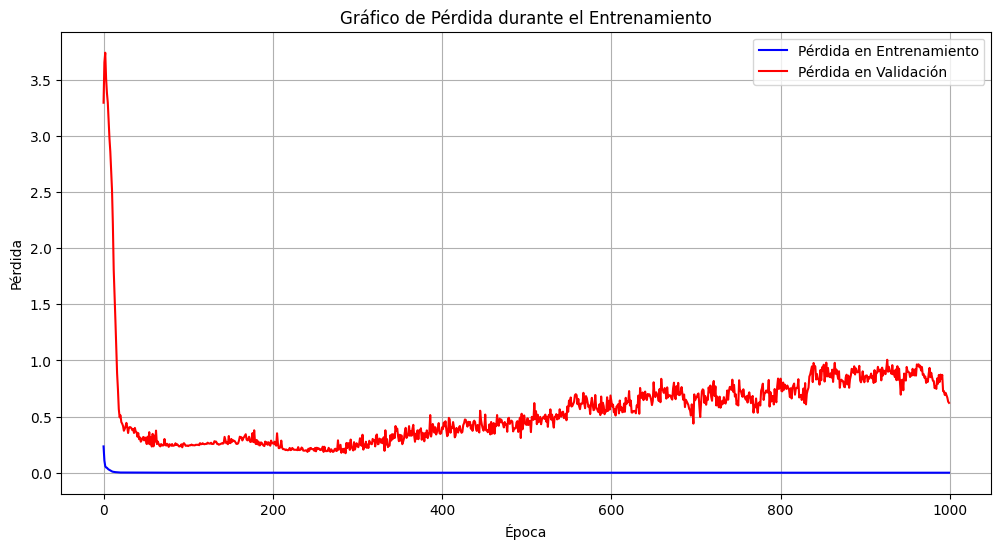

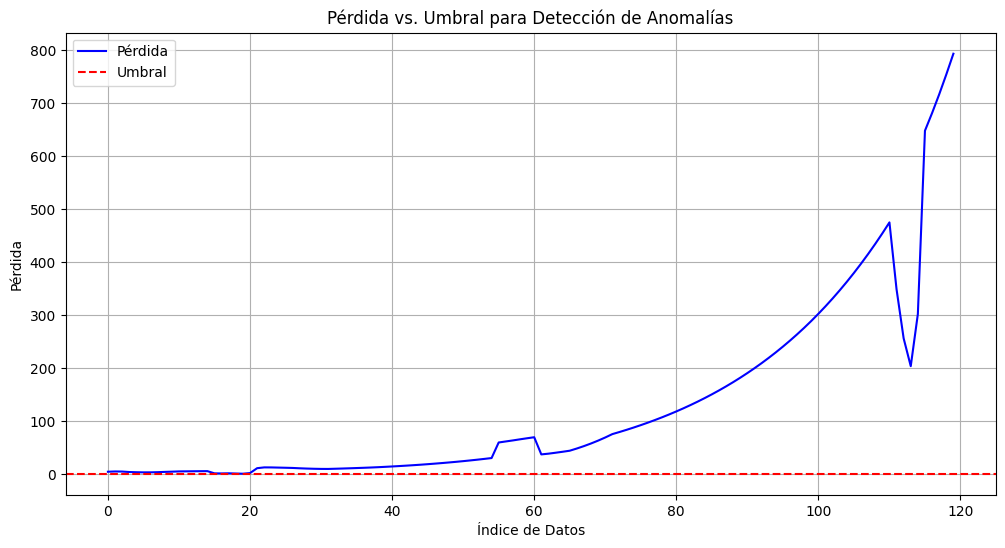

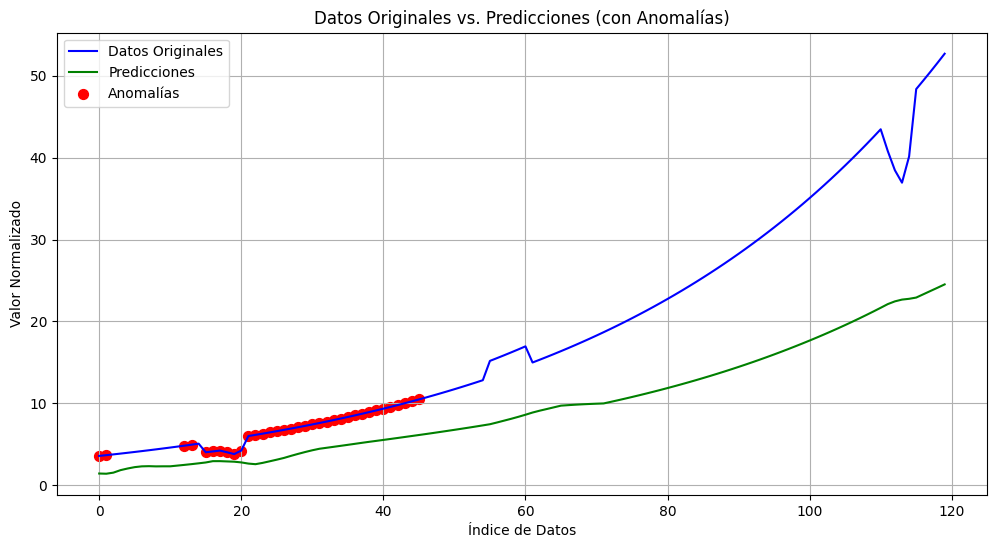

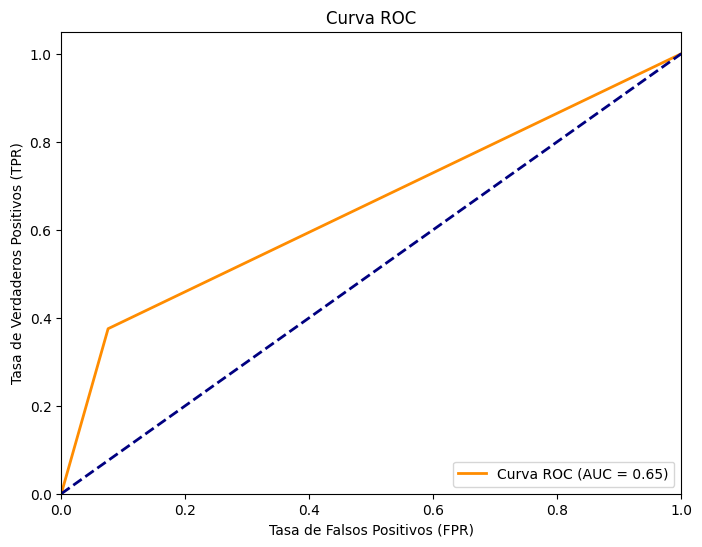

In [27]:
#CREACION DEL MODELO AUTOENCODER CON CAPAS DENSAS

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],X_train.shape[2])),
    tf.keras.layers.Dense(best_params['num_units1'], activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(best_params['num_units2'], activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(best_params['num_units3'], activation='relu'),
    tf.keras.layers.LSTM(best_params['num_units3'], activation='relu', return_sequences=True),  # Agregar capa LSTM tanh talvez
    tf.keras.layers.Dense(best_params['num_units2'], activation='relu'),
    tf.keras.layers.Dense(best_params['num_units1'], activation='relu'),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(X_train.shape[2], activation='linear'))])

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, X_train, epochs=1000, batch_size=best_params['batch_size'], validation_split=0.2, verbose=0)
mse = model.evaluate(X_train, X_train, verbose=0)

a = pd.DataFrame(X_test[0].flat)
b = pd.DataFrame(y_test)
datos_testeo = pd.concat((a,b)).reset_index(drop=True)

predictions = model.predict(X_test)
predicciones1 = pd.DataFrame(predictions[0].flat)
predicciones2 = pd.DataFrame(predictions.flat)[TIME_STEPS-(1)::TIME_STEPS]
predicciones = pd.concat((predicciones1, predicciones2))

predicciones.reset_index(drop=True, inplace=True)
datos_testeo.reset_index(drop=True, inplace=True)

loss = history.history['loss']
val_loss = history.history['val_loss']

df_test = pd.DataFrame()
df_test['x_test'] = datos_testeo
df_test['predic'] = predicciones
df_test['error'] = df_test['x_test'] - df_test['predic']
df_test['error2'] = df_test['error']**2

# Gráfico de Pérdida en Entrenamiento y Validación

plt.figure(figsize=(12, 6))
plt.plot(loss, label='Pérdida en Entrenamiento', color='blue')
plt.plot(val_loss, label='Pérdida en Validación', color='red')
plt.legend()
plt.title('Gráfico de Pérdida durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.grid(True)

# Gráfico de Pérdida y Umbral para Detección de Anomalías

plt.figure(figsize=(12, 6))
plt.plot(df_test.index, df_test.error2, label='Pérdida', color='blue')
plt.axhline(y=threshold, color='red', linestyle='--', label='Umbral')
plt.title('Pérdida vs. Umbral para Detección de Anomalías')
plt.xlabel('Índice de Datos')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)

# Gráfico de Datos Originales vs. Predicciones (con Anomalías)

plt.figure(figsize=(12, 6))
plt.plot(datos_testeo, label='Datos Originales', color='blue')
plt.plot(predicciones, label='Predicciones', color='green')
plt.scatter(anomalias.index, anomalias['x_test'], color='red', label='Anomalías', marker='o', s=50)
plt.title('Datos Originales vs. Predicciones (con Anomalías)')
plt.xlabel('Índice de Datos')
plt.ylabel('Valor Normalizado')
plt.legend()
plt.grid(True)

#endogeneizar el umbral
#1. encontrar el umbral que maximice el recall DONE
#2. F1 score
#3. optimizar
# 
etiqueta = data[empresa1]
predic = pd.DataFrame()
predic = pd.DataFrame({'Valor': [0] * len(data[empresa1])})

predic.loc[anomalias.index + valor1, 'Valor'] = 1
confusion = confusion_matrix(etiqueta, predic)

TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

print("Verdaderos Positivos (TP):", TP)
print("Verdaderos Negativos (TN):", TN)
print("Falsos Positivos (FP):", FP)
print("Falsos Negativos (FN):", FN)
precision = precision_score(etiqueta, predic)
recall = recall_score(etiqueta, predic)
f1 = f1_score(etiqueta, predic)
print(f"Precisión: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
fpr, tpr, thresholds = roc_curve(etiqueta, predic)
roc_auc = auc(fpr, tpr)
print("Área bajo la curva (AUC): {:.2f}".format(roc_auc))

fpr, tpr, _ = roc_curve(etiqueta, predic)
roc_auc = roc_auc_score(etiqueta, predic)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

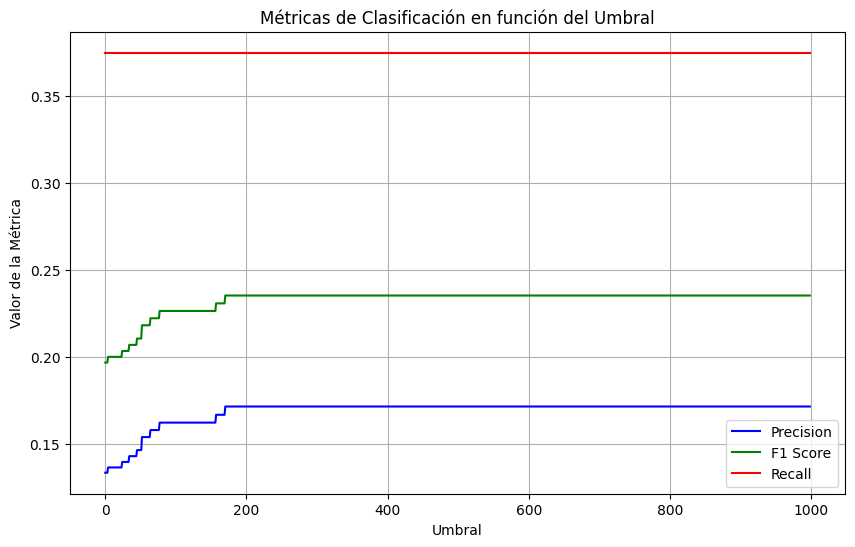

In [14]:
y = []
for x in range(1,1000):
    y.append((x/1000))
pre = []
rec = []
f1 = []
optimos =[]
for i in y:
    threshold = i
    anomalias = df_test[df_test['error2'] > threshold]
    etiqueta = data[empresa1]
    predic = pd.DataFrame()
    predic = pd.DataFrame({'Valor': [0] * len(data[empresa1])})
    predic.loc[anomalias.index+valor1, 'Valor'] = 1
    precision = precision_score(etiqueta, predic,zero_division=0)
    recall = recall_score(etiqueta, predic,zero_division=0)
    f = f1_score(etiqueta, predic,zero_division=0)
    pre.append(precision)
    rec.append(recall)
    f1.append(f)
    
    
    if f > 0.9:
        optimos.append(threshold)

plt.figure(figsize=(10, 6))
plt.plot(pre, label='Precision', color='blue')
plt.plot(f1, label='F1 Score', color='green')
plt.plot(rec, label='Recall', color='red')
plt.legend()
plt.xlabel('Umbral')
plt.ylabel('Valor de la Métrica')
plt.title('Métricas de Clasificación en función del Umbral')
plt.grid(True) 
plt.show()

In [15]:
# Convierte las listas en arrays de numpy para facilitar la manipulación
pre = np.array(pre)
rec = np.array(rec)
f1 = np.array(f1)

# Encuentra el índice del umbral que maximiza F1
indice_umbral_optimo = np.argmax(f1)

# Obtiene el umbral óptimo
umbral_optimo = y[indice_umbral_optimo]

Verdaderos Positivos (TP): 6
Verdaderos Negativos (TN): 355
Falsos Positivos (FP): 29
Falsos Negativos (FN): 10
Precisión: 0.17142857142857143
Recall: 0.375
F1-Score: 0.23529411764705876


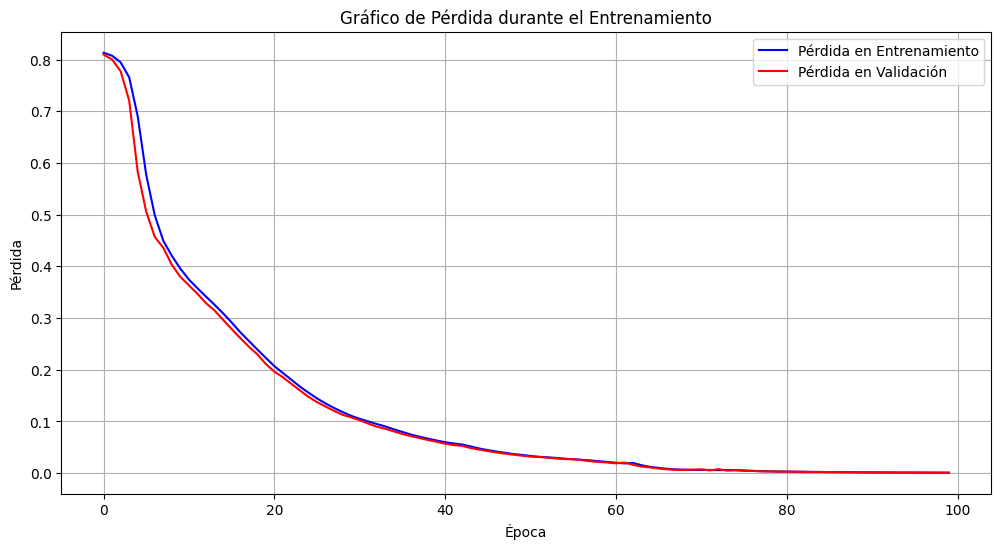

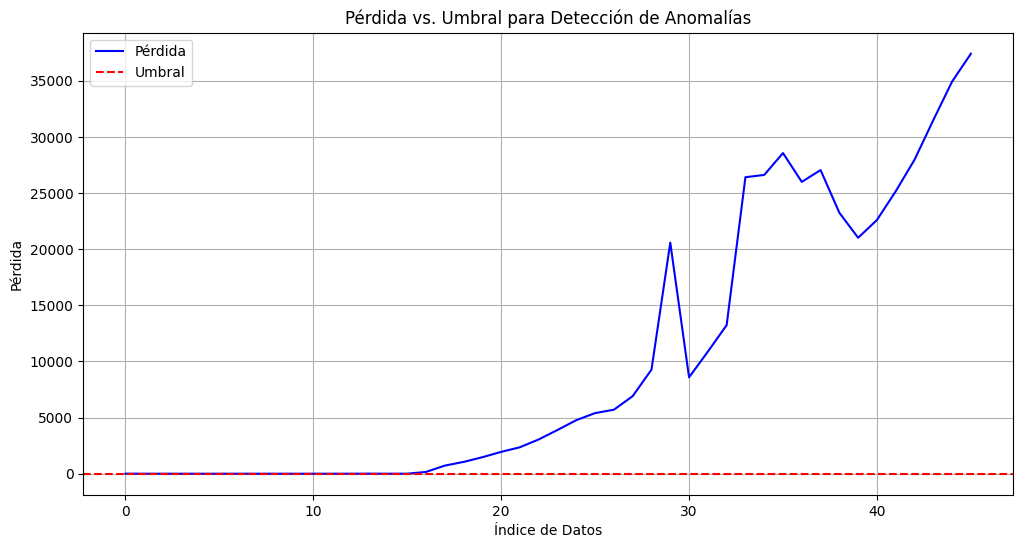

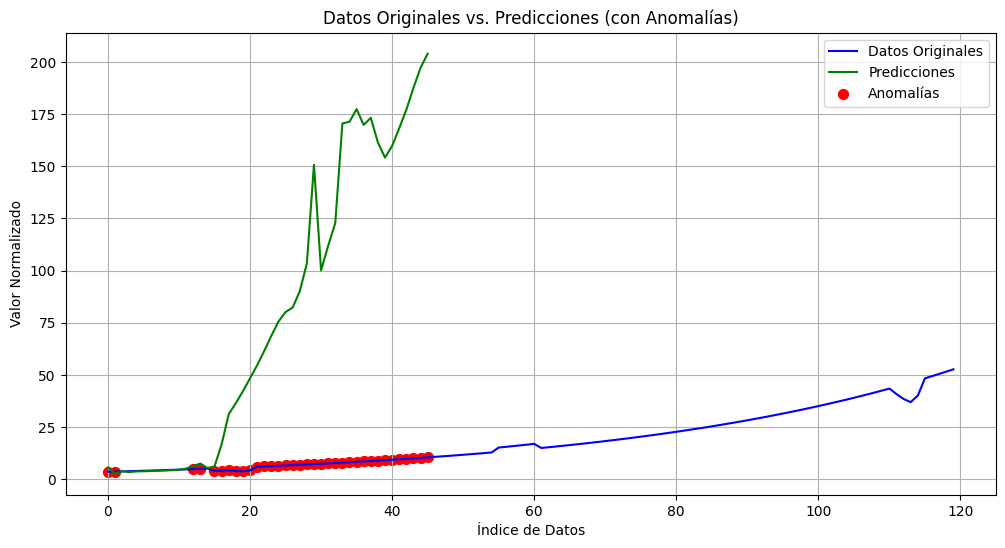

In [16]:
#### REEMPLAZAR ###
threshold = umbral_optimo

anomalias = df_test[df_test['error2'] > threshold] #ANOMALIA DE ACUERDO A LO QUE SEA MAYOR AL THRESHOLD

# Gráfico de Pérdida en Entrenamiento y Validación

plt.figure(figsize=(12, 6))
plt.plot(loss, label='Pérdida en Entrenamiento', color='blue')
plt.plot(val_loss, label='Pérdida en Validación', color='red')
plt.legend()
plt.title('Gráfico de Pérdida durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.grid(True)

# Gráfico de Pérdida y Umbral para Detección de Anomalías

plt.figure(figsize=(12, 6))
plt.plot(df_test.index, df_test.error2, label='Pérdida', color='blue')
plt.axhline(y=threshold, color='red', linestyle='--', label='Umbral')
plt.title('Pérdida vs. Umbral para Detección de Anomalías')
plt.xlabel('Índice de Datos')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)

# Gráfico de Datos Originales vs. Predicciones (con Anomalías)

plt.figure(figsize=(12, 6))
plt.plot(datos_testeo, label='Datos Originales', color='blue')
plt.plot(predicciones, label='Predicciones', color='green')
plt.scatter(anomalias.index, anomalias['x_test'], color='red', label='Anomalías', marker='o', s=50)
plt.title('Datos Originales vs. Predicciones (con Anomalías)')
plt.xlabel('Índice de Datos')
plt.ylabel('Valor Normalizado')
plt.legend()
plt.grid(True)

#endogeneizar el umbral
#1. encontrar el umbral que maximice el recall DONE
#2. F1 score
#3. optimizar
# 
etiqueta = data[empresa1]
predic = pd.DataFrame()
predic = pd.DataFrame({'Valor': [0] * len(data[empresa1])})

predic.loc[anomalias.index + valor1, 'Valor'] = 1
confusion = confusion_matrix(etiqueta, predic)

TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

print("Verdaderos Positivos (TP):", TP)
print("Verdaderos Negativos (TN):", TN)
print("Falsos Positivos (FP):", FP)
print("Falsos Negativos (FN):", FN)
precision = precision_score(etiqueta, predic)
recall = recall_score(etiqueta, predic)
f1 = f1_score(etiqueta, predic)
print(f"Precisión: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

In [17]:
valor1

280

In [18]:
fpr, tpr, thresholds = roc_curve(predicciones, predic[340:])
roc_auc = auc(fpr, tpr)
print("Área bajo la curva (AUC): {:.2f}".format(roc_auc))

fpr, tpr, _ = roc_curve(etiqueta, predic)
roc_auc = roc_auc_score(etiqueta, predic)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

ValueError: continuous format is not supported